In [1]:
%load_ext Cython

In [118]:
%pylab inline
import seaborn

Populating the interactive namespace from numpy and matplotlib


In [245]:
from SuchTree import SuchTree
import pandas as pd

T1 = SuchTree( 'SuchTree/tests/test.tree' )
T2 = SuchTree( 'http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_unique_2_clustalo_fasttree.tree' )
links = pd.read_csv( 'http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_host_count_table.tsv', 
                    sep='\t', index_col='Host')
links.index = map( lambda x : x.replace(' ','_'), links.index )

In [120]:
from SuchTree import SuchTree
import pandas as pd
import numpy as np

T1 = SuchTree( 'SuchTree/tests/test.tree' )
T2 = SuchTree( 'SuchTree/tests/test.tree' )
links = pd.DataFrame( np.random.random_integers( 0, 3, size=(14,14) ), index=T1.leafs.keys(), columns=T1.leafs.keys() )

In [228]:
%%cython
import cython
import numpy as np
from cpython.mem cimport PyMem_Malloc, PyMem_Free
from SuchTree import SuchTree

cdef struct Column :
    unsigned int length
    unsigned int leaf_id
    unsigned int* links

cdef class SuchLinkedTree :
    
    cdef Column* table
    cdef unsigned int table_size
    
    cdef object TreeA
    cdef object TreeB
    
    cdef object row_ids
    cdef object row_names
    cdef object col_ids
    cdef object col_names
    
    cdef unsigned int n_rows
    cdef unsigned int n_cols
    cdef unsigned int n_links
    
    cdef object np_table
    cdef object np_linklist
    
    cdef object linked_leafsA
    cdef object linked_leafsB
    
    cdef object subset_columns
    cdef object subset_leafs
    cdef unsigned int subset_size
    cdef unsigned int subset_n_links
    
    def __cinit__( self, tree_a, tree_b, link_matrix ) :
        cdef unsigned int i
        self.table_size = link_matrix.shape[1]
        self.table = <Column*> PyMem_Malloc( self.table_size * sizeof( Column ) )
        for i in xrange( self.table_size ) :
            self.table[i].length = 0
            self.table[i].leaf_id = 0
            self.table[i].links = NULL
    
    def __init__( self, tree_a, tree_b, link_matrix ) :
        
        # these objects are constructed only when first accessed
        self.np_table = None
        self.np_linklist = None
        self.linked_leafsA = None
        self.linked_leafsB = None
        self.col_ids = None
        self.row_ids = None
        self.col_names = None
        self.row_names = None
        self.subset_columns = None
        self.subset_leafs = None
        
        # build trees from newick files, URLs to newick files or 
        # from existing SuchTrees
        if type( tree_a ) == str : 
            self.TreeA = SuchTree( tree_a )
        elif type( tree_a ) == SuchTree :
            self.TreeA = tree_a
        else :
            raise Exception( 'unknown input for tree', type(tree_a) )
        
        # build trees from newick files, URLs to newick files or 
        # from existing SuchTrees
        if type( tree_b ) == str : 
            self.TreeB = SuchTree( tree_b )
        elif type( tree_b ) == SuchTree :
            self.TreeB = tree_b
        else :
            raise Exception( 'unknown input for tree', type(tree_b) )
            
        # make sure the link matrix connects the trees
        if not link_matrix.shape == ( self.TreeA.n_leafs, self.TreeB.n_leafs ) :
            raise Exception( 'link_matrix shape must match tree leaf counts' )
        
        if not set(link_matrix.axes[0]) == set(self.TreeA.leafs.keys()) :
            raise Exception( 'axis[0] does not match TreeA leaf names' )
        
        if not set(link_matrix.axes[1]) == set(self.TreeB.leafs.keys()) :
            raise Exception( 'axis[1] does not match TreeB leaf names' )

        # set row and column indexes
        self.row_ids = np.array( self.TreeA.leafs.values() )
        self.col_ids = np.array( self.TreeB.leafs.values() )
        self.row_names = self.TreeA.leafs.keys()
        self.col_names = self.TreeB.leafs.keys()
        
        self.n_rows = self.TreeA.n_leafs
        self.n_cols = self.TreeB.n_leafs
        
        print id(self), 'allocating columns in', <unsigned int> &self.table
        self.n_links = 0
        for i in xrange( self.table_size ) :
            self.TreeB.link_leaf( self.col_ids[i], i )
            s = link_matrix[ link_matrix.columns[i] ]
            l = map( lambda x : self.TreeA.leafs[x], s[ s > 0 ].to_dict().keys() )
            col_size = len(l)
            if self.table[i].links == NULL :
                self.table[i].leaf_id = self.col_ids[i]
                self.n_links += col_size
                self.table[i].length = col_size
                self.table[i].links = <unsigned int*> PyMem_Malloc( col_size * sizeof( unsigned int ) )
                for j in xrange( col_size ) :
                    self.table[i].links[j] = l[j]
    
        # by default, the subset is the whole table
        self.subset_size = len( self.col_ids )
        self.subset_n_links = self.n_links
        self.subset_columns = np.array( range( self.subset_size ) )
        self.subset_leafs = self.col_ids
        
        # make np_linklist
        self.np_linklist = np.ndarray( ( self.n_links, 2 ), dtype=int )
        self._build_linklist()
    
    def __dealloc__( self ) :
        
        print id(self), 'freeing columns in', <unsigned int> &self.table
        
        for i in xrange( self.table_size ) :
            if not self.table[i].links == NULL :
                PyMem_Free( self.table[i].links ) 
        
        print id(self), 'freeing table', <unsigned int> &self.table
        
        PyMem_Free( self.table )
    
    property TreeA :
        'first tree initialized by SuchLinkedTrees( TreeA, TreeB )'
        def __get__( self ) :
            return self.TreeA
    
    property TreeB :
        'second tree initialized by SuchLinkedTrees( TreeA, TreeB )'
        def __get__( self ) :
            return self.TreeB

    property n_links :
        'size of the link list'
        def __get__( self ) :
            return self.n_links   
     
    property n_cols :
        'Number of columns in the link matrix.'
        def __get__( self ) :
            return self.n_cols
    
    property n_rows :
        'Number of rows in the link matrix.'
        def __get__( self ) :
            return self.n_rows
    
    property col_ids :
        'ids of the columns (TreeB) in the link matrix.'
        def __get__( self ) :
            if self.col_ids is None :
                self.col_ids = self.TreeB.leafs.values()
            return self.col_ids
    
    property row_ids :
        'ids of the rows (TreeA) in the link matrix.'
        def __get__( self ) :
            if self.row_ids is None :
                self.row_ids = self.TreeA.leafs.values()
            return self.row_ids
    
    property col_names :
        'Names of the columns (TreeB) in the link matrix.'
        def __get__( self ) :
            if self.col_names is None :
                self.col_names = self.TreeB.leafs.keys()
            return self.col_names
    
    property row_names :
        'Names of the rows (TreeA) in the link matrix.'
        def __get__( self ) :
            if self.col_ids is None :
                self.row_names = self.TreeA.leafs.keys()
            return self.row_names
    
    property subset_columns :
        'ids of the current subset columns.'
        def __get__( self ) :
            return self.subset_columns
    
    property subset_leafs :
        'ids of the current subset columns.'
        def __get__( self ) :
            return self.subset_leafs
    
    property subset_size :
        'Number of columns in the current subset.'
        def __get__( self ) :
            return self.subset_size
        
    property subset_n_links :
        'Number of columns in the current subset.'
        def __get__( self ) :
            return self.subset_n_links
    
    property linkmatrix :
        'numpy representation of link matrix (generated only on access)'
        def __get__( self ) :
            cdef unsigned int i
            cdef unsigned int j
            cdef unsigned int row_id
            
            if self.np_table is None :
                
                self.np_table = np.zeros( (self.n_rows,self.n_cols), dtype=bool )
                
                for i in xrange( self.n_cols ) :
                    for j in xrange( self.table[i].length ) :
                        row_id = np.where( self.row_ids == self.table[i].links[j] )[0][0]
                        self.np_table[ i, row_id ] = True
                        
            return self.np_table
        
    property linklist :
        'numpy representation of link list (generated only on access)'
        def __get__( self ) :
            # actual length will be shorter when with subsetted link matrixes
            return self.np_linklist[:self.subset_n_links-1,:]
        
    cdef _build_linklist( self ) :
            cdef unsigned int i
            cdef unsigned int j
            cdef unsigned int col
            cdef unsigned int k = 0
            
            for i in xrange( self.subset_size ) :
                col = self.subset_columns[i]
                #print i, col 
                for j in xrange( self.table[col].length ) :
                    #self.np_linklist[ k, 0 ] = self.table[col].leaf_id
                    self.np_linklist[ k, 0 ] = self.subset_leafs[i]
                    self.np_linklist[ k, 1 ] = self.table[col].links[j]
                    k += 1
            
            self.subset_n_links = k
            
    def subset( self, node_id ) :
        'subset the link matrix to leafs desended from node_id'
        self.subset_leafs = self.TreeB.get_leafs( node_id )
        self.subset_columns = self.TreeB.get_links( self.subset_leafs )
        self.subset_size = len( self.subset_columns )
        self._build_linklist()
    
    def linked_distances( self ) :
        """
        Compute distances for all pairs of links. For large link
        tables, this will fail on memory allocation.
        """
        cdef unsigned int i
        cdef unsigned int j
        cdef unsigned int k = 0
        cdef unsigned int size = ( self.subset_n_links * (self.subset_n_links-1) ) / 2 
        
        ids_a = np.ndarray( ( size, 2 ), dtype=int )
        ids_b = np.ndarray( ( size, 2 ), dtype=int )
                
        for i in xrange( self.subset_n_links ) :
            for j in xrange( i ) :
                ids_a[ k, 0 ] = self.np_linklist[ i, 0 ]
                ids_a[ k, 1 ] = self.np_linklist[ j, 0 ]
                ids_b[ k, 0 ] = self.np_linklist[ i, 1 ]
                ids_b[ k, 1 ] = self.np_linklist[ j, 1 ]
                k += 1
        #return ids_a, ids_b
        return { 'TreeA' : self.TreeA.distances( ids_a ), 
                 'TreeB' : self.TreeB.distances( ids_b ) }
    
    def dump_table( self ) :
        'Print the link matrix (WARNING : may be huge and useless)'
        for i in xrange( self.n_cols ) :
            col = []
            for j in xrange( self.table[i].length ) :
                #row_id = np.where( self.row_ids == self.table[i].links[j] )[0][0]
                row_id = self.table[i].links[j]
                col.append( row_id )
            print 'column', i, ':', ','.join( map( str, col ) )



In [246]:
SLT = SuchLinkedTree( T1, T2, links )
SLT = SuchLinkedTree( T1, T2, links )

140140808576848 allocating columns in 320675688
140141674001808 freeing columns in 1186100648
140141674001808 freeing table 1186100648
140141674001808 allocating columns in 1186100648
140140808576848 freeing columns in 320675688
140140808576848 freeing table 320675688


In [247]:
SLT.dump_table()

column 0 : 2,20,10,14,0,22,12,18,24,8,16,26
column 1 : 2,0,4,24,14
column 2 : 2,0,16,24,8,26
column 3 : 2,20,6,10,14,0,22,12,18,24,8,4,26
column 4 : 2,20,10,14,0,22,12,18,24,8,4,26
column 5 : 2,0,16,24,8,26
column 6 : 2,0,16,24,26
column 7 : 20,14,0,22,12,18,24,8,16
column 8 : 2,10,14,0,18,24,8,4,26
column 9 : 24
column 10 : 8,24
column 11 : 0,16,24,8
column 12 : 0,16,24,26
column 13 : 2,0,24
column 14 : 0,24,20
column 15 : 2,16,24
column 16 : 2,20,6,10,14,0,22,18,24,8,4,26
column 17 : 2,0,16,24,8
column 18 : 2,0,8,24,14
column 19 : 2,10,0,12,18,24,4,26
column 20 : 8,24
column 21 : 0,4,24
column 22 : 2,20,6,0,22,18,24,8,26
column 23 : 0,24
column 24 : 24
column 25 : 8,24
column 26 : 16,24
column 27 : 10,8,22,18,24,26
column 28 : 2,14,24,8
column 29 : 20,14,0,18,24,8
column 30 : 0,24,8
column 31 : 2,0,18,24,8
column 32 : 2,8,16,24
column 33 : 2,0,16,24,8,26
column 34 : 2,20,14,0,24,8,26
column 35 : 2,0,16,24,8,26
column 36 : 0,24,8
column 37 : 2,14,4,24,8
column 38 : 0,24
column 39 : 8,

In [231]:
SLT.linkmatrix

array([[False, False, False, False,  True, False, False,  True, False,
        False,  True, False, False, False],
       [ True, False, False,  True,  True, False,  True,  True,  True,
         True, False,  True, False,  True],
       [ True,  True, False, False,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True],
       [ True,  True, False,  True, False, False, False,  True,  True,
         True,  True,  True, False,  True],
       [ True, False,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True],
       [False,  True,  True,  True, False,  True,  True, False, False,
         True,  True,  True, False,  True],
       [False,  True,  True,  True,  True,  True,  True, False, False,
         True,  True,  True,  True,  True],
       [ True, False, False,  True,  True, False,  True,  True,  True,
         True, False,  True,  True,  True],
       [False,  True,  True, False,  True,  True, False,  True,  True,
         

In [232]:
SLT.linklist

array([[ 2, 22],
       [ 2, 10],
       [ 2, 24],
       [20,  2],
       [20, 10],
       [20,  0],
       [20, 22],
       [20, 12],
       [20, 18],
       [20,  8],
       [20, 16],
       [20, 26],
       [ 6,  2],
       [ 6, 20],
       [ 6, 10],
       [ 6, 14],
       [ 6,  0],
       [ 6, 22],
       [ 6, 12],
       [ 6, 16],
       [ 6, 24],
       [ 6,  4],
       [ 6, 26],
       [18,  2],
       [18, 20],
       [18,  8],
       [18, 22],
       [18, 12],
       [18, 18],
       [18, 24],
       [18, 16],
       [18, 26],
       [10,  2],
       [10,  6],
       [10, 10],
       [10, 14],
       [10,  8],
       [10, 22],
       [10, 12],
       [10, 18],
       [10, 24],
       [10, 16],
       [10,  4],
       [10, 26],
       [14, 20],
       [14,  6],
       [14, 14],
       [14,  0],
       [14, 18],
       [14, 24],
       [14,  8],
       [14, 16],
       [14, 26],
       [ 0, 20],
       [ 0,  6],
       [ 0, 10],
       [ 0, 14],
       [ 0,  0],
       [ 0, 18

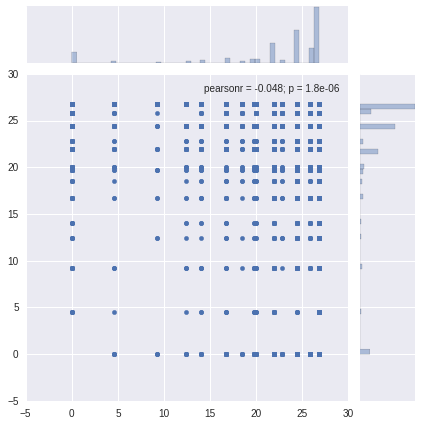

In [233]:
result = SLT.linked_distances()

seaborn.jointplot( result['TreeA'], result['TreeB'] )

In [234]:
SLT.TreeB.get_internal_nodes()

array([21, 19, 25, 13, 23,  7, 17,  1, 11, 15,  3,  9,  5])

In [235]:
SLT.TreeB.get_leafs( 23 )

array([22, 24])

In [259]:
SLT.subset( 7337 )
print SLT.subset_size, SLT.subset_n_links

2858 7693


In [243]:
print SLT.col_ids
print SLT.subset_columns
print SLT.subset_leafs

[ 2 20  6 18 10 14  0 22 12 16 24  8  4 26]
[ 6  8  0 11  4 12  2]
[ 0 12  2  8 10  4  6]


Exception Exception: Exception('query contains out of bounds id',) in 'SuchTree.SuchTree._distances' ignored


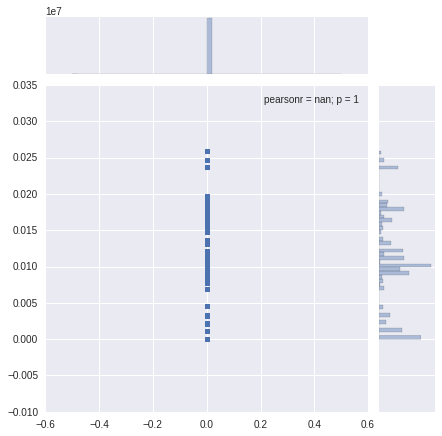

In [260]:
result = SLT.linked_distances()

seaborn.jointplot( result['TreeA'], result['TreeB'] )

In [174]:
result

(array([[ 2,  2],
        [ 2,  2],
        [ 2,  2],
        ..., 
        [26, 26],
        [26, 26],
        [26, 26]]), array([[10, 22],
        [24, 22],
        [24, 10],
        ..., 
        [26, 24],
        [26, 16],
        [26,  4]]))